In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Load Data
merged_df = pd.read_csv("Test_Prop_2016.csv")
merged_df.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxdelinquencyflag,taxpercentage
0,11016594,0.0276,2016-01-01,1.0,0.0,2.0,3.0,4.0,2.0,0.0,...,0.0,1959.0,1.0,0,122754.0,360170.0,2015.0,237416.0,0,0.018702
1,14366692,-0.1684,2016-01-01,5.0,0.0,3.5,4.0,7.0,3.5,0.0,...,0.0,2014.0,1.0,0,346458.0,585529.0,2015.0,239071.0,0,0.017340
2,12098116,-0.0040,2016-01-01,1.0,0.0,3.0,2.0,4.0,3.0,0.0,...,0.0,1940.0,1.0,0,61994.0,119906.0,2015.0,57912.0,0,0.095779
3,12643413,0.0218,2016-01-02,1.0,0.0,2.0,2.0,4.0,2.0,0.0,...,0.0,1987.0,1.0,0,171518.0,244880.0,2015.0,73362.0,0,0.012450
4,14432541,-0.0050,2016-01-02,5.0,0.0,2.5,4.0,7.0,2.5,0.0,...,0.0,1981.0,2.0,0,169574.0,434551.0,2015.0,264977.0,0,0.012631


In [4]:
# Remove ID columns
x_train = merged_df.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
x_train.head()

#### Stability Selection via Randomized Lasso

In a nutshell, this method serves to apply the feature selection on different parts of the data and features repeatedly until the results can be aggregated. Therefore stronger features ( defined as being selected as important) will have greater scores in this method as compared to weaker features. Refer to this paper by Nicolai Meinshausen and Peter Buhlmann for a much greater detail on the method : http://stat.ethz.ch/~nicolai/stability.pdf

In this notebook, the Stability Selection method is conveniently inbuilt into sklearn's randomized lasso model and therefore this will be implemented as follows:

In [10]:
# First extract the target variable which is our Log Error
Y = merged_df['logerror'].values
X = x_train.as_matrix()

# Store the column/feature names into a list "colnames"
colnames = x_train.columns

C:\Users\myang\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Next, we create a function which will be able to conveniently store our feature rankings obtained from the various methods described here into a Python dictionary. In case you are thinking I created this function, no this is not the case. All credit goes to Ando Saabas and I am only trying to apply what he has discussed in this context.

In [11]:
# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [12]:
# Finally let's run our Selection Stability method with Randomized Lasso
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), colnames)
print('finished')

C:\Users\myang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


finished


#### Recursive Feature Elimination ( RFE )

Now onto the next method in our feature ranking endeavour. Recursive Feature Elimination or RFE uses a model ( eg. linear Regression or SVM) to select either the best or worst-performing feature, and then excludes the feature. After this, the whole process is iterated until all features in the dataset are used up ( or up to a user-defined limit). Sklearn conveniently possesses a RFE function via the sklearn.feature_selection call and we will use this along with a simple linear regression model for our ranking search as follows:

In [13]:
# Construct our Linear Regression model
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(X,Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 fe

#### Linear Model Feature Ranking

Now let's apply 3 different linear models (Linear, Lasso and Ridge Regression) and how the features are selected and prioritised via these models. To achieve this, I shall use the sklearn implementation of these models and in particular the attribute .coef to return the estimated coefficients for each feature in the linear model.

In [14]:
# Using Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(X,Y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

C:\Users\myang\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


#### Random Forest feature ranking

Sklearn's Random Forest model also comes with it's own inbuilt feature ranking attribute and one can conveniently just call it via "featureimportances". That is what we will be using as follows:

In [15]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=2)
rf.fit(X,Y)
ranks["RF"] = ranking(rf.feature_importances_, colnames)

building tree 1 of 50building tree 2 of 50building tree 3 of 50
building tree 4 of 50


building tree 5 of 50building tree 6 of 50
building tree 7 of 50

building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.2s


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.2s finished


#### Creating the Feature Ranking Matrix

We combine the scores from the various methods above and output it in a matrix form for convenient viewing as such:

In [16]:
# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	Lasso	LinReg	RF	RFE	Ridge	rlasso/Stability	Mean
airconditioningtypeid	0.0	0.0	0.07	0.59	0.03	0.0	0.12
basementsqft	0.0	0.0	0.0	0.54	0.0	0.0	0.09
bathroomcnt	0.0	0.0	0.13	0.74	0.02	0.0	0.15
bedroomcnt	0.0	0.0	0.2	0.72	0.02	0.0	0.16
buildingqualitytypeid	0.0	0.0	0.09	0.51	0.01	0.0	0.1
calculatedbathnbr	0.0	0.0	0.09	0.79	0.06	0.0	0.16
decktypeid	0.0	0.0	0.01	0.85	0.52	0.0	0.23
calculatedfinishedsquarefeet	0.49	0.0	0.42	0.36	0.0	0.0	0.21
finishedsquarefeet15	0.0	0.0	0.41	0.38	0.0	0.0	0.13
finishedsquarefeet50	0.16	0.0	0.41	0.28	0.0	0.0	0.14
fips	0.0	0.0	0.01	0.56	0.41	0.0	0.16
fireplacecnt	0.0	0.0	0.02	0.9	0.18	0.0	0.18
garagecarcnt	0.0	0.0	0.02	0.67	0.02	0.0	0.12
garagetotalsqft	0.03	0.0	0.12	0.26	0.0	0.0	0.07
hashottuborspa	0.0	0.0	0.02	0.82	0.45	0.0	0.22
heatingorsystemtypeid	0.0	0.0	0.07	0.64	0.04	0.0	0.12
latitude	0.0	0.0	0.92	0.0	0.0	0.0	0.15
longitude	0.0	0.0	0.88	0.03	0.0	0.0	0.15
lotsizesquarefeet	0.0	0.0	0.91	0.05	0.0	0.0	0.16
poolcnt	0.0	1.0	0.03	0.95	0.02	0.0	0.33
poolsizesum	

In [17]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

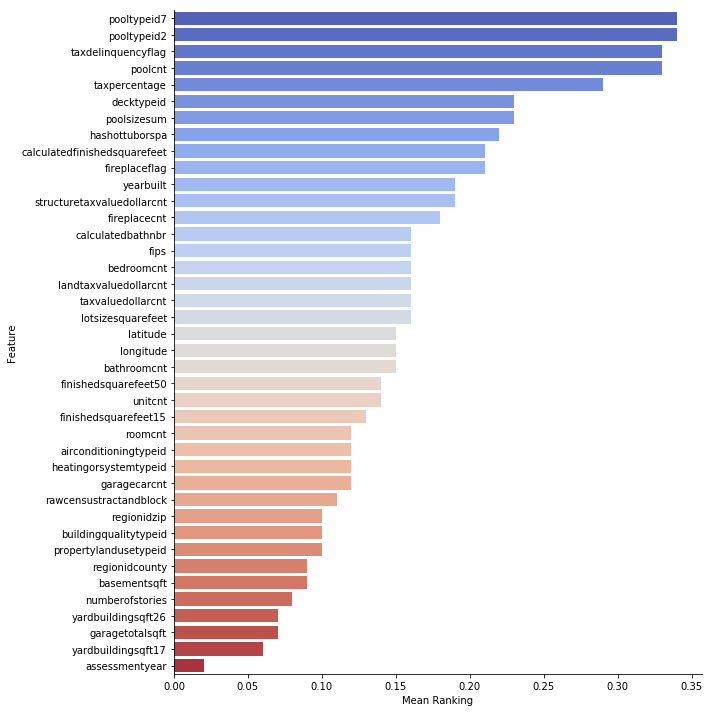

In [18]:
# Let's plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", size=10, aspect=1, palette='coolwarm')